## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [ ]:
cd ..

Install additional packages directly from the requirements file

In [ ]:
# pip install -r requirements.in --quiet

### Load packages

In [ ]:
%load_ext autoreload
%autoreload 2

# import os
# import xarray as xr
# import pandas as pd
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from concurrent.futures import ProcessPoolExecutor

# import datacube
import odc.geo.xr
# from datacube.utils.cog import write_cog
# from datacube.utils.geometry import Geometry
# from odc.algo import mask_cleanup, xr_quantile

from dea_tools.dask import create_local_dask_cluster
# from dea_tools.coastal import pixel_tides
# from intertidal.elevation import (
#     load_data,
#     ds_to_flat,
#     pixel_rolling_median,
#     pixel_dem,
#     pixel_uncertainty,
#     flat_to_ds,
#     elevation,
# )
# from intertidal.utils import load_config, export_intertidal_rasters

# # Connect to datacube
# dc = datacube.Datacube(app="Intertidal_elevation")

## Setup


### Set analysis parameters

##### Optional: load study area using interactive map

In [ ]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(10, 135), zoom=2)
study_area = "usa"

## Load data

In [ ]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

In [ ]:
# pip install planetary_computer

In [ ]:
def pc_load(
    product,
    time=None,
    x=None,
    y=None,
    geom=None,
    stac_query=None,
    url="https://planetarycomputer.microsoft.com/api/stac/v1",
    **load_params,
):
    """
    Loads data from Microsoft Planetary Computer into an
    `xarray.Dataset` using `odc-stac`.

    Parameters
    ----------
    product : str
        The name of the product to load.
    time : tuple, optional
        The time range to load data for as a tuple of strings (e.g.
        `("2020", "2021")`. If not provided, data will be loaded for
        all available timesteps.
    x, y : tuple, optional
        Tuples defining the x and y bounding box to load, in WGS 84.
    geom : datacube Geometry, optional
        A datacube geometry object representing the spatial extents to
        load data for. If provided, `x` and `y` will be ignored.
    stac_query : dict, optional
        A query dictionary to further filter the data using STAC metadata.
        If not provided, no additional filtering will be applied.
    url : str, optional
        The URL of the Planetary Computer STAC API.
        Defaults to "https://planetarycomputer.microsoft.com/api/stac/v1".
    **load_params : dict
        Additional parameters to be passed to `odc.stac.load()`.

    Returns
    -------
    ds : xarray.Dataset
        The loaded dataset as an `xarray.Dataset`.
    items : pystac.item_collection.ItemCollection
        STAC items returned by `pystac_client`.
    """

    import odc.stac
    import planetary_computer
    import pystac_client
    from odc.geo.geom import BoundingBox

    # Connect to client
    catalog = pystac_client.Client.open(
        url,
        modifier=planetary_computer.sign_inplace
        if "planetarycomputer" in url
        else None,
    )

    # Set up query
    if geom is not None:
        bbox = geom.boundingbox
    else:
        bbox = BoundingBox.from_xy(x, y)
    time_range = "/".join(time) if time is not None else None

    search = catalog.search(
        collections=product,
        bbox=bbox,
        datetime=time_range,
        query=stac_query if stac_query is not None else None,
    )

    # Check how many items were returned
    items = search.item_collection()
    print(f"Found {len(items)} STAC items for {product}")

    # Load with ODC STAC
    ds = odc.stac.load(
        items=items,
        bbox=bbox,
        **load_params,
    )

    return ds, items


load_params = dict(
    bands=("red", "green", "blue"),
    crs="utm",
    resolution=10,
    chunks={"x": 3000, "y": 3000},
    groupby="solar_day",
    resampling="nearest",
)

In [ ]:
ds_ls, items_ls = pc_load(
    product="landsat-c2-l2",
    time=("1980-01", "2015-03"),
    geom=geom,
    # x=(54.933875, 55.047778),
    # y=(25.045205, 24.955804),
    stac_query={
        "eo:cloud_cover": {"lt": 5},
        "platform": {"in": ["landsat-5", "landsat-8", "landsat-9"]},
        "landsat:collection_category": {"in": ["T1"]},
    },
    **load_params,
)

ds_ls = (ds_ls.where(ds_ls != 0) * 0.0000275 + -0.2).clip(0, 1)
# ds_ls.load()

In [ ]:
ds_s2, items_s2 = pc_load(
    product="sentinel-2-l2a",
    time=("2015-03", "2023-07"),
    geom=geom,
    # x=(54.933875, 55.047778),
    # y=(25.045205, 24.955804),
    stac_query={
        "eo:cloud_cover": {"lt": 5},
        "platform": {"in": ["landsat-5", "landsat-8", "landsat-9"]},
    },
    **load_params,
)

ds_s2 = (ds_s2.where(ds_s2 > 0) / 10000).clip(0, 1)
ds_s2.load()

In [ ]:
from dea_tools.plotting import xr_animation

In [ ]:
# xr_animation(
#     ds_ls.dropna(dim="time", how="all").rolling(time=25, center=True, min_periods=1).median() ** 0.6,
#     percentile_stretch=(0.02, 0.99),
#     bands=["red", "green", "blue"],
#     interval=50,
#     width_pixels=900,
#     output_path='animation_median_large.mp4',
# )

In [ ]:
ds_combined = xr.concat([ds_ls, ds_s2], dim="time").sortby("time")

In [ ]:
xr_animation(
    ds_combined.dropna(dim="time", how="any") ** 0.6,
    percentile_stretch=(0.02, 0.99),
    bands=["red", "green", "blue"],
    interval=50,
    width_pixels=800
)

In [ ]:
xr_animation(
    ds_combined.dropna(dim="time", how="all").rolling(time=15, center=True, min_periods=1).median() ** 0.6,
    percentile_stretch=(0.02, 0.99),
    bands=["red", "green", "blue"],
    interval=50,
    width_pixels=800,
    output_path='animation_median.mp4',
)

Found 4 STAC items for landsat-c2-l2


/env/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


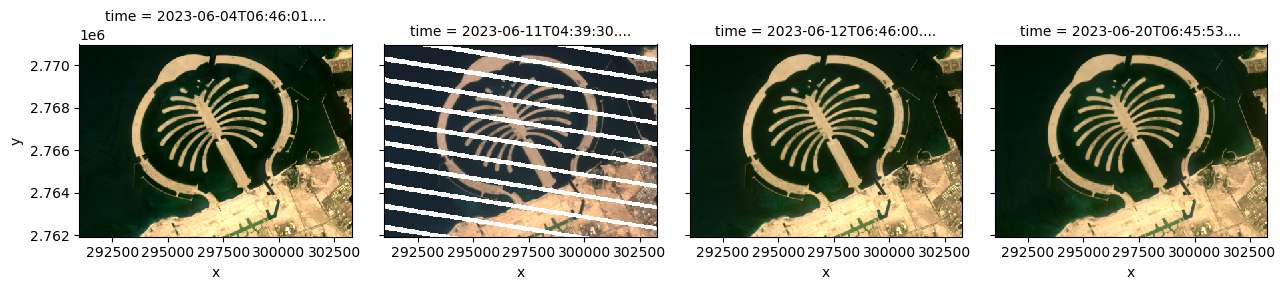

In [1]:

ds, items = pc_load(
    product="landsat-c2-l2",
    bands=("red", "green", "blue"),
    time=("2023-06", "2023-06"),
    x=(54.93, 55.05),
    y=(25.04, 24.96),
    stac_query={"eo:cloud_cover": {"lt": 25}},
    crs="utm",
    resolution=30,
    groupby="solar_day",
)

ds_rescaled = (ds.where(ds != 0) * 0.0000275 + -0.2).clip(0, 1)
ds_rescaled.to_array().plot.imshow(col="time", robust=True)